In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_excel("sample.xlsx", list = 'data')

In [3]:
df.head()

,customer_month_salary,sum_credit_current,term_credit_current,form,sphere,type,EDUCATION,age,marital_status,time_at_work,GENDER,month_passport_issued,month_with_bank,CITY,target,ID
0,52350.25,500000,59,ООО,"Наука, Образование, Здравоохранение",вспомогательный персонал,высшее,44,холост / не замужем,68.0,мужской,124,67.0,Москва,1,1
1,115000.00,400000,60,Иная форма,Другое,специалист,высшее,30,холост / не замужем,96.0,мужской,107,68.0,Москва,1,2
2,87000.00,361000,60,ОАО,"Финансы, управляющие компании, банки, страхование",специалист,Высшее/Второе высшее/Ученая степень,28,женат / замужем,117.0,женский,2,72.0,Москва,1,3
3,145358.17,1499000,60,ЗАО,"Финансы, управляющие компании, банки, страхование",менеджер среднего звена,Высшее/Второе высшее/Ученая степень,30,женат / замужем,35.0,мужской,124,70.0,Москва,1,4
4,50000.00,365000,60,ООО,Другое,специалист,среднее-специальное,31,холост / не замужем,48.0,мужской,131,88.0,Москва,1,5


In [4]:
df.shape

(4771, 16)

In [5]:
where_are_NaNs = np.isnan(df.month_with_bank)
df.month_with_bank[where_are_NaNs] = 0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df = df.dropna()

In [7]:
df.shape

(4704, 16)

In [8]:
import seaborn as sns

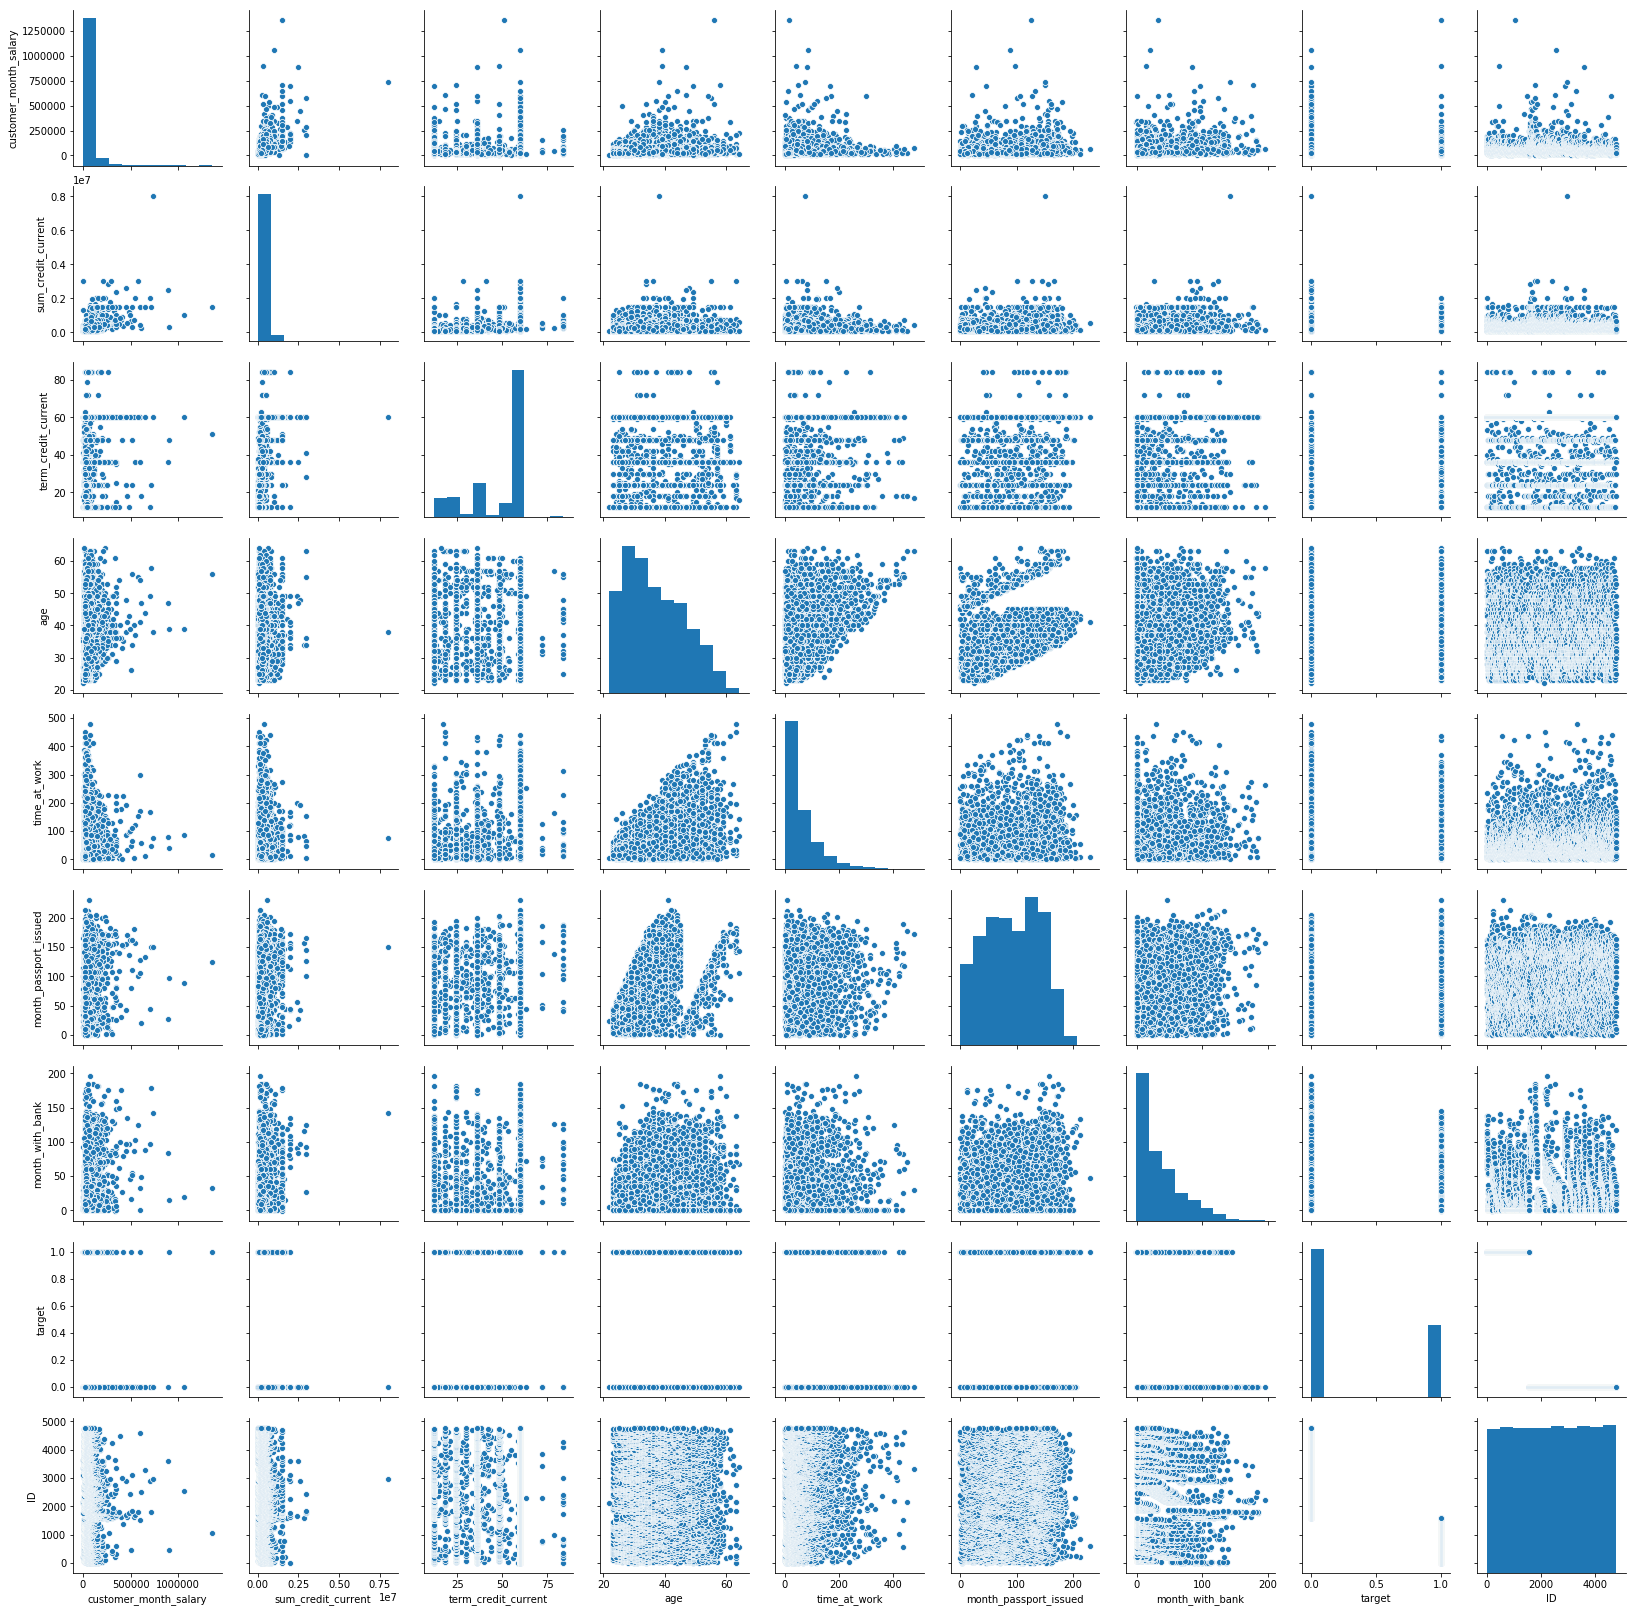

In [9]:
sns.pairplot(df)

In [10]:
correlations = df.corr()['target'].sort_values()

print('Most Positive Correlations:\n', correlations.tail())
print('\nMost Negative Correlations:\n', correlations.head())

Most Positive Correlations:
 time_at_work          -0.074773
sum_credit_current    -0.050378
age                   -0.041755
term_credit_current    0.138097
target                 1.000000
Name: target, dtype: float64

Most Negative Correlations:
 ID                      -0.813835
month_with_bank         -0.189055
month_passport_issued   -0.111190
customer_month_salary   -0.085756
time_at_work            -0.074773
Name: target, dtype: float64


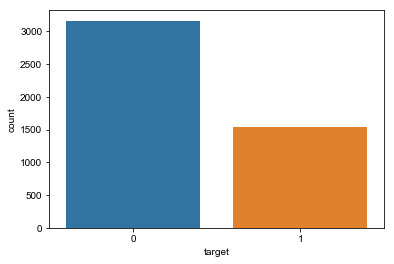

In [11]:
df['target'].value_counts()
sns.countplot(df['target'])
sns.set_style('whitegrid')

## Feature Engineering

In [12]:
df['myFeature4'] = (12 * (df.sum_credit_current/df.term_credit_current)) / ((df.customer_month_salary + 0.1) * 12)
df['myFeature1'] = np.log(df.customer_month_salary + 0.1)
df['myFeature2'] = (df.term_credit_current + df.month_with_bank) / df.term_credit_current
df['myFeature3'] = df.time_at_work / df.age

df = df.drop("ID", axis=1)

In [13]:
new_with_dummies = pd.get_dummies(df, drop_first=True)

In [14]:
from sklearn.model_selection import train_test_split

In [108]:
y = new_with_dummies["target"]
X = new_with_dummies.drop('target', axis = 1)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 0)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
X_train.shape, y_train.shape

((3292, 113), (3292,))

## Feature Selection with LGBM

In [18]:
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [110]:
features = [c for c in X.columns]
target = y_train

In [111]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'dart',
    'feature_fraction': 0.05,
    'learning_rate': 0.0123,
    'max_depth': 6,  
    'metric':'auc',
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 10.0,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [112]:
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=44000)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 80)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 80 rounds.
[200]	training's auc: 0.731947	valid_1's auc: 0.65952
Early stopping, best iteration is:
[136]	training's auc: 0.741333	valid_1's auc: 0.669542
Fold 1
Training until validation scores don't improve for 80 rounds.
[200]	training's auc: 0.744804	valid_1's auc: 0.653107
Early stopping, best iteration is:
[153]	training's auc: 0.740578	valid_1's auc: 0.659867
Fold 2
Training until validation scores don't improve for 80 rounds.
Early stopping, best iteration is:
[64]	training's auc: 0.727441	valid_1's auc: 0.69168
CV score: 0.57032 


C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


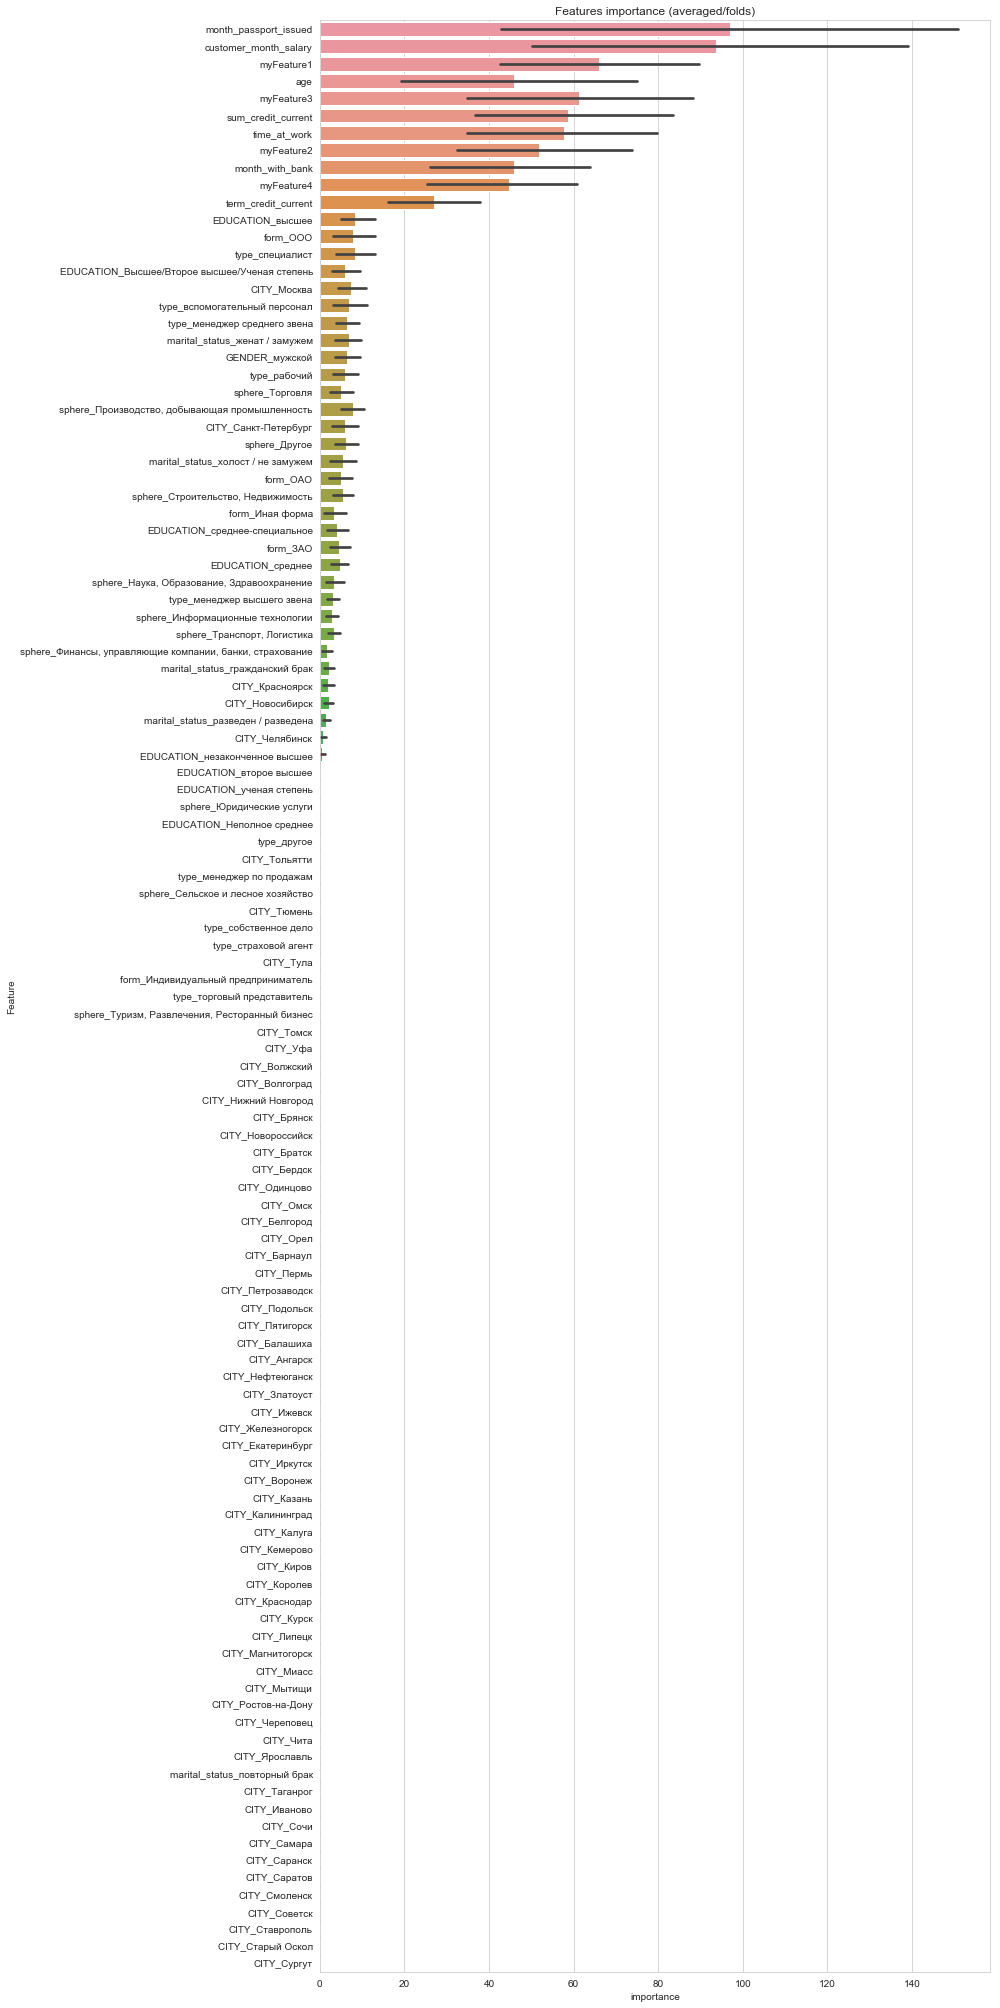

In [28]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
#plt.savefig('FI.png')

In [35]:
y_pred = pd.DataFrame(predictions)

In [55]:
y_pred.head()

,0
0,0.490913
1,0.493349
2,0.489691
3,0.493328
4,0.493947


In [72]:
# tunned threshold
y_predd = np.where(y_pred > 0.4934, 1, 0)

In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [73]:
print('Accuracy: % .2f' % accuracy_score(y_test, y_predd))

CM = confusion_matrix(y_pred=y_predd, y_true=y_test)
print(CM)

Accuracy:  0.68
[[902  40]
 [415  55]]


In [74]:
correlations = df.corr()['target'].sort_values()

print('Most Positive Correlations:\n', correlations.tail())
print('\nMost Negative Correlations:\n', correlations.head())

Most Positive Correlations:
 sum_credit_current    -0.050378
age                   -0.041755
myFeature4            -0.015384
term_credit_current    0.138097
target                 1.000000
Name: target, dtype: float64

Most Negative Correlations:
 month_with_bank         -0.189055
myFeature2              -0.179114
month_passport_issued   -0.111190
customer_month_salary   -0.085756
myFeature1              -0.084193
Name: target, dtype: float64


## Models

In [79]:
X = X[["month_passport_issued", "time_at_work", "myFeature3", "myFeature4", "customer_month_salary", "sum_credit_current", "myFeature2", "month_with_bank", "age", "term_credit_current"]]

In [80]:
y =df["target"]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 0)

In [82]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


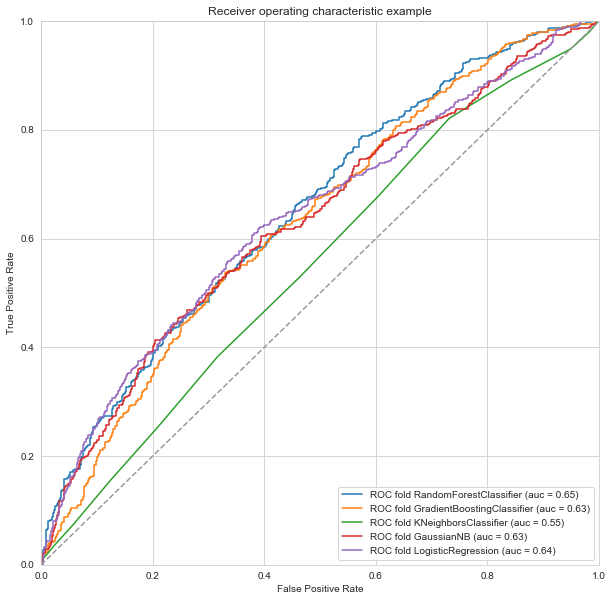

In [86]:
models = []
models.append(RandomForestClassifier(n_estimators=165, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(n_estimators=1000, max_depth=3))
models.append(KNeighborsClassifier(n_neighbors=20))
models.append(GaussianNB())
models.append(LogisticRegression())
#models.append(SVC())

# roc_auc plot
plt.figure(figsize=(10, 10)) 
for model in models:
    model.fit(X_train, y_train)
    pred_scr = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, pred_scr)
    roc_auc = auc(fpr, tpr)
    md = str(model)
    md = md[:md.find('(')]
    plt.plot(fpr, tpr, label='ROC fold %s (auc = %0.2f)' % (md, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### В конце концов, построим Логит.

In [90]:
from sklearn.preprocessing import StandardScaler

In [91]:
scl = StandardScaler()

In [95]:
scl.fit_transform(X_train)
scl.fit_transform(X_test)

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 1.40759815, -0.45750052, -0.51934306, ..., -0.10577805,
         0.07334136, -0.78532901],
       [ 1.50921005, -0.72860877, -0.82858702, ..., -0.98419139,
        -0.13650262,  0.69458143],
       [-0.52302778, -0.32194639, -0.01795348, ...,  0.14924518,
        -1.18572252, -2.26523945],
       ...,
       [-1.31560053, -0.23157697,  0.13950771, ...,  0.00756561,
        -1.18572252,  0.69458143],
       [-1.7220481 ,  0.25039326,  0.10393315, ...,  0.94265078,
         0.80779529, -0.78532901],
       [ 0.49309113, -0.83403976, -0.93472752, ...,  0.03590152,
        -0.76603456, -0.78532901]])

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logit=LogisticRegression()
logit_cv=GridSearchCV(logit, grid, cv=10)
logit_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logit_cv.best_params_)
print("accuracy :",logit_cv.best_score_)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklea

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklea

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklea

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklea

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
accuracy : 0.6825637910085055


C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
logitTuned = LogisticRegression(penalty= 'l1', C = 0.01)

In [101]:
logitTuned.fit(X_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [102]:
y_pred = logitTuned.predict(X_test)

In [106]:
roc_auc_score(y_test, y_pred)

0.5564462212585265